In [2]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, log_loss, classification_report

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

In [3]:
# Process Pokémon and one-hot encode the types

pokemon = pd.read_csv('../data/external/stats/pokemon.csv')
pokemon["Variety"] = float("NaN")
pokemon = pokemon[["#", "Name", "Variety", "Type 1", "Type 2"]]

# Create one-hot columns for each type
types = set(pokemon["Type 1"])
for t in types:
    pokemon["is" + str(t)] = 0

# Iterate over Pokémon
for i, p in pokemon.iterrows():
    
    # Clean up name
    pokemonName = pokemon.loc[i, "Name"]
    pokemonName = pokemonName.replace(" ", "")
    
    pokemonNameComponents = re.findall('[A-Z][^A-Z0-9]*', pokemonName)

    pokemon.loc[i, "Name"] = pokemonNameComponents[0]
    
    # Set variety (Mega etc.)
    if len(pokemonNameComponents) > 1:
        pokemonNameComponents = [value for value in pokemonNameComponents if value != pokemonNameComponents[0]]
        pokemon.loc[i, "Variety"] = str(pokemonNameComponents).lower()
    else:
        pokemon.loc[i, "Variety"] = "normal"
    
    #  Set one-hot columns to 1 for relevant types
    pokemon.loc[i, "is" + p["Type 1"]] = 1

#     if not pd.isna(p["Type 2"]):
#         pokemon.loc[i, "is" + p["Type 2"]] = 1

# Ditch all Pokemon with varieties (e.g. Megas):
pokemon = pokemon[pokemon["Variety"] == "normal"]


# Save output
pokemon.to_csv('../data/processed/pokemon.csv', index=False)

pokemon.head()

,#,Name,Variety,Type 1,Type 2,isFighting,isGround,isWater,isRock,isSteel,...,isIce,isDragon,isFlying,isNormal,isFairy,isPsychic,isGhost,isBug,isElectric,isFire
0,1,Bulbasaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Charmander,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,5,Charmeleon,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# Process image data

data_directory_images = "../data/external/images-gen-1-6"
output_directory = "../data/processed/pokemon"

pokemon = pd.read_csv('../data/processed/pokemon.csv')
pokemon["imagePath"] = np.nan

# Remove processed folder and create empty new one
try:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
except:
    os.mkdir(output_directory)

# Copy images to processed folder
for image in os.listdir(data_directory_images):
    pokemon_id = image.split('.')[0]

    # Images with no variety (e.g. "211.png")
    if pokemon_id.isnumeric():
        
        # Copy to processed folder
        src = data_directory_images + "/" + image
        dst = output_directory + "/" + pokemon_id + ".png"

        shutil.copyfile(src, dst)

        # Set image path in data frame
        pokemon.loc[pokemon["#"] == int(pokemon_id), 'imagePath'] = dst
        

# Drop Pokemon without image path
pokemon = pokemon.dropna(subset=["imagePath"])

# Save pokemon.csv with image paths
pokemon.to_csv('../data/processed/pokemon-with-image-paths.csv', index=False)

pokemon.head()

,#,Name,Variety,Type 1,Type 2,isFighting,isGround,isWater,isRock,isSteel,...,isDragon,isFlying,isNormal,isFairy,isPsychic,isGhost,isBug,isElectric,isFire,imagePath
0,1,Bulbasaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,../data/processed/pokemon/1.png
1,2,Ivysaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,../data/processed/pokemon/2.png
2,3,Venusaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,../data/processed/pokemon/3.png
3,4,Charmander,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,../data/processed/pokemon/4.png
4,5,Charmeleon,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,../data/processed/pokemon/5.png


In [5]:
# Load images as training data
train_image = []

for i in tqdm(range(pokemon.shape[0])):
    
    img = tf.keras.utils.load_img(pokemon.iloc[i]["imagePath"], color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

X.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 693/693 [00:01<00:00, 508.18it/s]


(693, 256, 256, 4)

In [10]:
# Create labels
y = pokemon[["isWater"]]
y.shape

(693, 1)

In [11]:
print(sum(y["isWater"]))

101


In [19]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(554, 256, 256, 4) (554, 1)
(139, 256, 256, 4) (139, 1)


In [21]:
print(sum(y_train["isWater"]))

81


In [42]:
# # Create model

img_input = layers.Input(shape=(256, 256, 4))

# Define layers
# x = layers.Conv2D(filters=32, kernel_size=(6, 6), activation='relu', padding='same')(img_input)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)
# x = layers.Dropout(0.20)(x)

# x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)
# x = layers.Dropout(0.20)(x)

# x = layers.Flatten()(x)

# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dropout(0.20)(x)

# x = layers.Dense(64, activation='tanh')(x)
# x = layers.Dropout(0.20)(x)

# x = layers.Dense(32, activation='tanh')(x)
# x = layers.Dropout(0.10)(x)

# x = layers.Dense(16, activation='tanh')(x)
# x = layers.Dropout(0.05)(x)

# output = layers.Dense(1, activation='softmax')(x)

x = layers.Conv2D(filters=3, kernel_size=(8, 8), activation='tanh')(img_input)
x = layers.MaxPool2D()(x)

# x = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='relu')(x)
# x = layers.MaxPool2D()(x)

# x = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='relu')(x)
# x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation='relu')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(units=1, activation='sigmoid')(x)




model = keras.Model(inputs=img_input, outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.001) #Adam, RMSprop or SGD

model.compile(
    optimizer=optimizer,                 
    loss='binary_crossentropy',
#     metrics=['accuracy', keras.metrics.AUC()]
    metrics=[keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 4)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 249, 249, 3)       771       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 124, 124, 3)      0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 46128)             0         
                                                                 
 dense_22 (Dense)            (None, 1)                 46129     
                                                                 
 dropout_11 (Dropout)        (None, 1)                 0         
                                                          

In [38]:
# Train model

estimator = model.fit(
    X_train
  , y_train
  , epochs=10
  , validation_data=(X_test, y_test)
  , batch_size=200
 )


Epoch 1/10


2022-08-24 10:55:07.869242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 308ms/step - loss: 0.9609 - auc_6: 0.5406 - val_loss: 0.4607 - val_auc_6: 0.5836
Epoch 2/10


2022-08-24 10:55:08.844459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 147ms/step - loss: 0.6827 - auc_6: 0.4837 - val_loss: 0.6920 - val_auc_6: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 144ms/step - loss: 0.6918 - auc_6: 0.5000 - val_loss: 0.6912 - val_auc_6: 0.5000
Epoch 4/10
3/3 [==============================] - 0s 133ms/step - loss: 0.6909 - auc_6: 0.5000 - val_loss: 0.6902 - val_auc_6: 0.5000
Epoch 5/10
3/3 [==============================] - 0s 136ms/step - loss: 0.6899 - auc_6: 0.5110 - val_loss: 0.6892 - val_auc_6: 0.5000
Epoch 6/10
3/3 [==============================] - 0s 132ms/step - loss: 0.6889 - auc_6: 0.5000 - val_loss: 0.6881 - val_auc_6: 0.5000
Epoch 7/10
3/3 [==============================] - 0s 132ms/step - loss: 0.6878 - auc_6: 0.5000 - val_loss: 0.6870 - val_auc_6: 0.5000
Epoch 8/10
3/3 [==============================] - 0s 127ms/step - loss: 0.6868 - auc_6: 0.5000 - val_loss: 0.6860 - val_auc_6: 0.5000
Epoch 9/10
3/3 [==============================] - 0s 129ms/step - loss: 0

In [25]:
def predict_pokemon(id):
    
    img = tf.keras.utils.load_img(f'../data/processed/pokemon/{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,256,256,4))
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]
    
    
#     print(format(proba[0][0], '.100f'))

2022-08-24 10:48:22.296667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 279ms/step
Bulbasaur False 0.15286969
1/1 [==============================] - 0s 11ms/step
Ivysaur False 0.12078123
1/1 [==============================] - 0s 11ms/step
Venusaur False 0.23564917
1/1 [==============================] - 0s 10ms/step
Charmander False 0.13563341
1/1 [==============================] - 0s 10ms/step
Charmeleon False 0.181967
1/1 [==============================] - 0s 11ms/step
Charizard False 0.21256915
1/1 [==============================] - 0s 12ms/step
Squirtle True 0.16925825
1/1 [==============================] - 0s 10ms/step
Wartortle True 0.11975737
1/1 [==============================] - 0s 11ms/step
Blastoise True 0.18923199
1/1 [==============================] - 0s 11ms/step
Caterpie False 0.16507103
1/1 [==============================] - 0s 11ms/step
Metapod False 0.2412662
1/1 [==============================] - 0s 11ms/step
Butterfree False 0.09737405
1/1 [==============================] - 0s 10ms/step
Weedle Fa

1/1 [==============================] - 0s 11ms/step
Hitmonchan False 0.35766208
1/1 [==============================] - 0s 11ms/step
Lickitung False 0.11736821
1/1 [==============================] - 0s 11ms/step
Koffing False 0.1759091
1/1 [==============================] - 0s 11ms/step
Weezing False 0.16915345
1/1 [==============================] - 0s 11ms/step
Rhyhorn False 0.22354783
1/1 [==============================] - 0s 10ms/step
Rhydon False 0.17387635
1/1 [==============================] - 0s 11ms/step
Chansey False 0.08648859
1/1 [==============================] - 0s 10ms/step
Tangela False 0.17327887
1/1 [==============================] - 0s 10ms/step
Kangaskhan False 0.14671849
1/1 [==============================] - 0s 11ms/step
Horsea True 0.15521124
1/1 [==============================] - 0s 11ms/step
Seadra True 0.13452363
1/1 [==============================] - 0s 11ms/step
Goldeen True 0.16798717
1/1 [==============================] - 0s 10ms/step
Seaking True 0.06050947

1/1 [==============================] - 0s 10ms/step
Sneasel False 0.15941586
1/1 [==============================] - 0s 10ms/step
Teddiursa False 0.13319647
1/1 [==============================] - 0s 10ms/step
Ursaring False 0.19391204
1/1 [==============================] - 0s 10ms/step
Slugma False 0.17054412
1/1 [==============================] - 0s 11ms/step
Magcargo False 0.21258165
1/1 [==============================] - 0s 11ms/step
Swinub False 0.29857206
1/1 [==============================] - 0s 10ms/step
Piloswine False 0.20939918
1/1 [==============================] - 0s 10ms/step
Corsola True 0.12805586
1/1 [==============================] - 0s 11ms/step
Remoraid True 0.1773337
1/1 [==============================] - 0s 11ms/step
Octillery True 0.2501385
1/1 [==============================] - 0s 10ms/step
Delibird False 0.12829743
1/1 [==============================] - 0s 10ms/step
Mantine True 0.27897033
1/1 [==============================] - 0s 11ms/step
Skarmory False 0.28545

1/1 [==============================] - 0s 10ms/step
Wailord True 0.2738423
1/1 [==============================] - 0s 10ms/step
Numel False 0.11130998
1/1 [==============================] - 0s 10ms/step
Camerupt False 0.15468496
1/1 [==============================] - 0s 10ms/step
Torkoal False 0.12788858
1/1 [==============================] - 0s 10ms/step
Spoink False 0.22429036
1/1 [==============================] - 0s 10ms/step
Grumpig False 0.14211173
1/1 [==============================] - 0s 10ms/step
Spinda False 0.17656553
1/1 [==============================] - 0s 10ms/step
Trapinch False 0.14734787
1/1 [==============================] - 0s 10ms/step
Vibrava False 0.34808925
1/1 [==============================] - 0s 10ms/step
Flygon False 0.16263857
1/1 [==============================] - 0s 10ms/step
Cacnea False 0.23903033
1/1 [==============================] - 0s 10ms/step
Cacturne False 0.30643088
1/1 [==============================] - 0s 10ms/step
Swablu False 0.3556396
1/1 [=

Chingling False 0.24368136
1/1 [==============================] - 0s 10ms/step
Stunky False 0.23806189
1/1 [==============================] - 0s 11ms/step
Skuntank False 0.2240978
1/1 [==============================] - 0s 10ms/step
Bronzor False 0.2509371
1/1 [==============================] - 0s 10ms/step
Bronzong False 0.400012
1/1 [==============================] - 0s 10ms/step
Bonsly False 0.25212294
1/1 [==============================] - 0s 10ms/step
Happiny False 0.15785296
1/1 [==============================] - 0s 10ms/step
Chatot False 0.35662705
1/1 [==============================] - 0s 10ms/step
Spiritomb False 0.12191036
1/1 [==============================] - 0s 10ms/step
Gible False 0.15474941
1/1 [==============================] - 0s 10ms/step
Gabite False 0.29003185
1/1 [==============================] - 0s 10ms/step
Garchomp False 0.41715008
1/1 [==============================] - 0s 11ms/step
Munchlax False 0.23131488
1/1 [==============================] - 0s 10ms/step
R

1/1 [==============================] - 0s 10ms/step
Scolipede False 0.22357456
1/1 [==============================] - 0s 10ms/step
Cottonee False 0.12854584
1/1 [==============================] - 0s 10ms/step
Whimsicott False 0.10835585
1/1 [==============================] - 0s 10ms/step
Petilil False 0.23540711
1/1 [==============================] - 0s 10ms/step
Lilligant False 0.23803428
1/1 [==============================] - 0s 10ms/step
Sandile False 0.23407298
1/1 [==============================] - 0s 11ms/step
Krokorok False 0.21722868
1/1 [==============================] - 0s 10ms/step
Krookodile False 0.21550077
1/1 [==============================] - 0s 11ms/step
Darumaka False 0.11713101
1/1 [==============================] - 0s 11ms/step
Maractus False 0.3352968
1/1 [==============================] - 0s 11ms/step
Dwebble False 0.1758773
1/1 [==============================] - 0s 11ms/step
Crustle False 0.1961786
1/1 [==============================] - 0s 11ms/step
Scraggy False

1/1 [==============================] - 0s 10ms/step
Bunnelby False 0.2677432
1/1 [==============================] - 0s 11ms/step
Diggersby False 0.16562876
1/1 [==============================] - 0s 10ms/step
Fletchling False 0.18064903
1/1 [==============================] - 0s 10ms/step
Fletchinder False 0.22996697
1/1 [==============================] - 0s 10ms/step
Talonflame False 0.34417185
1/1 [==============================] - 0s 10ms/step
Scatterbug False 0.2928855
1/1 [==============================] - 0s 10ms/step
Spewpa False 0.13610286
1/1 [==============================] - 0s 11ms/step
Vivillon False 0.19925183
1/1 [==============================] - 0s 10ms/step
Litleo False 0.14117995
1/1 [==============================] - 0s 10ms/step
Pyroar False 0.16970718
1/1 [==============================] - 0s 10ms/step
Flabébé False 0.18151392
1/1 [==============================] - 0s 10ms/step
Floette False 0.2957941
1/1 [==============================] - 0s 10ms/step
Florges False

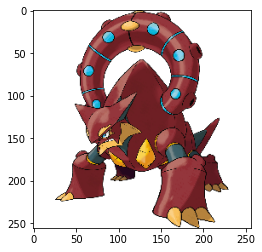

In [26]:
predicted_water = []
predicted_else = []

for i, row in pokemon.iterrows():
    y_true = row["isWater"] == 1
    y_pred = predict_pokemon(row["#"])
    
    print(row["Name"], y_true, y_pred)

#     if y_pred:
#         predicted_fire.append(y_pred)
#     else:
#         predicted_else.append(y_pred)
        
# print(predicted_fire)


1/1 [==============================] - 0s 16ms/step


0.02684345

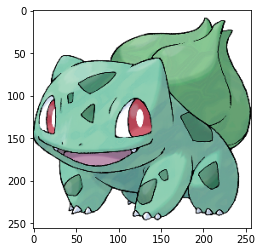

In [13]:
predict_pokemon("1")

Attribution:

https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080